In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import CuDNNLSTM, Activation, Dense, Dropout, LSTM
from keras.datasets import mnist
from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
import datetime
%matplotlib inline

In [2]:
data = pd.read_csv('Bitcoin_Nlp_Data.csv')
data = data.iloc[:,1:]
data.pop('Adj Close')
data

,Date,Open,High,Low,Close,Volume,Pos_score,Neg_score
0,2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,10291200000,0.145734,0.854266
1,2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,16846600192,0.279138,0.720862
2,2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,16871900160,0.213051,0.786949
3,2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,21783199744,0.201034,0.798966
4,2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,23840899072,0.227316,0.772684
...,...,...,...,...,...,...,...,...
1681,2022-08-09,23811.484375,23898.615234,22982.000000,23164.318359,23555719219,0.177060,0.822940
1682,2022-08-10,23162.898438,24127.414062,22771.519531,23947.642578,32837431722,0.155673,0.844327
1683,2022-08-11,23948.345703,24822.628906,23900.996094,23957.529297,37127036580,0.186520,0.813480
1684,2022-08-12,23957.203125,24412.566406,23657.265625,24402.818359,27265804688,0.181945,0.818055


In [3]:
data = data.set_index('Date')
data.index = pd.to_datetime(data.index)
data.head()

,Open,High,Low,Close,Volume,Pos_score,Neg_score
Date,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,10291200000,0.145734,0.854266
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,16846600192,0.279138,0.720862
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,16871900160,0.213051,0.786949
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,21783199744,0.201034,0.798966
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,23840899072,0.227316,0.772684


In [4]:
df = pd.DataFrame(data)
nd_column = df.pop('Close')
df.insert(6, 'Close',nd_column)
df.head()

,Open,High,Low,Volume,Pos_score,Neg_score,Close
Date,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,10291200000,0.145734,0.854266,13657.200195
2018-01-02,13625.000000,15444.599609,13163.599609,16846600192,0.279138,0.720862,14982.099609
2018-01-03,14978.200195,15572.799805,14844.500000,16871900160,0.213051,0.786949,15201.000000
2018-01-04,15270.700195,15739.700195,14522.200195,21783199744,0.201034,0.798966,15599.200195
2018-01-05,15477.200195,17705.199219,15202.799805,23840899072,0.227316,0.772684,17429.500000


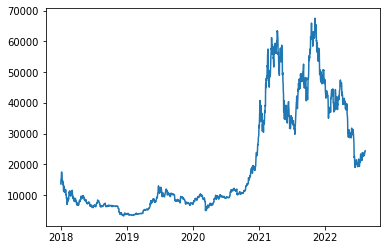

In [5]:
plt.plot(df.index, df['Close'])

In [6]:
#splitting the features
Close_df = df['Close']
Open_df = df['Open']
Low_df =df['Low']
High_df =df['High']
Volume_df =df['Volume']
Pos_df = df['Pos_score']
Neg_df = df['Neg_score']


In [7]:
#Sliding Window Function
def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [a for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [8]:
#Applying sliding window function to the features
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(Open_df, WINDOW_SIZE)
X2, y2 = df_to_X_y(Low_df, WINDOW_SIZE)
X3, y3 = df_to_X_y(High_df, WINDOW_SIZE)
X4, y4 = df_to_X_y(Volume_df, WINDOW_SIZE)
X5, y5 = df_to_X_y(Pos_df, WINDOW_SIZE)
X6, y6 = df_to_X_y(Neg_df, WINDOW_SIZE)
X7, y7 = df_to_X_y(Close_df, WINDOW_SIZE)

X5.shape, y5.shape

((1681, 5), (1681,))

In [9]:
#Naming the new columns
X1_df = pd.DataFrame(X1, columns = ['Open1', 'Open2', 'Open3', 'Open4', 'Open5'])
X2_df = pd.DataFrame(X2, columns = ['Low1', 'Low2', 'Low3', 'Low4', 'Low5'])
X3_df = pd.DataFrame(X3, columns = ['High1', 'High2', 'High3', 'High4', 'High5'])
X4_df = pd.DataFrame(X4, columns = ['Vol_1', 'Vol_2', 'Vol_3', 'Vol_4', 'Vol_5'])
X5_df = pd.DataFrame(X5, columns = ['Pos1', 'Pos2', 'Pos3', 'Pos4', 'Pos5'])
X6_df = pd.DataFrame(X6, columns = ['Neg1', 'Neg2', 'Neg3', 'Neg4', 'Neg5'])
X7_df = pd.DataFrame(X7, columns = ['Close1', 'Close2', 'Close3', 'Close4', 'Close5'])


In [10]:
#merging all the new features
frames = [X1_df,X2_df,X3_df,X4_df,X5_df,X6_df,X7_df]
df_f = pd.concat(frames,axis = 1)

In [11]:
df_f.shape

(1681, 35)

In [12]:
# saving the data in a csv
df_f.to_csv('merge_bit_nlp.csv',index=False)

In [13]:
df_f.shape

(1681, 35)

In [14]:
y_df = pd.DataFrame(y7, columns = ['Close'])

In [15]:
y_df

,Close
0,17527.000000
1,16477.599609
2,15170.099609
3,14595.400391
4,14973.299805
...,...
1676,23164.318359
1677,23947.642578
1678,23957.529297
1679,24402.818359


In [16]:
#merging both the independent and the dependent features
frames = [df_f,y_df]
df_2 = pd.concat(frames,axis = 1)

In [17]:
df_2

,Open1,Open2,Open3,Open4,Open5,Low1,Low2,Low3,Low4,Low5,...,Neg2,Neg3,Neg4,Neg5,Close1,Close2,Close3,Close4,Close5,Close
0,14112.200195,13625.000000,14978.200195,15270.700195,15477.200195,13154.700195,13163.599609,14844.500000,14522.200195,15202.799805,...,0.720862,0.786949,0.798966,0.772684,13657.200195,14982.099609,15201.000000,15599.200195,17429.500000,17527.000000
1,13625.000000,14978.200195,15270.700195,15477.200195,17462.099609,13163.599609,14844.500000,14522.200195,15202.799805,16764.599609,...,0.786949,0.798966,0.772684,0.775135,14982.099609,15201.000000,15599.200195,17429.500000,17527.000000,16477.599609
2,14978.200195,15270.700195,15477.200195,17462.099609,17527.300781,14844.500000,14522.200195,15202.799805,16764.599609,16087.700195,...,0.798966,0.772684,0.775135,0.787151,15201.000000,15599.200195,17429.500000,17527.000000,16477.599609,15170.099609
3,15270.700195,15477.200195,17462.099609,17527.300781,16476.199219,14522.200195,15202.799805,16764.599609,16087.700195,14208.200195,...,0.772684,0.775135,0.787151,0.825477,15599.200195,17429.500000,17527.000000,16477.599609,15170.099609,14595.400391
4,15477.200195,17462.099609,17527.300781,16476.199219,15123.700195,15202.799805,16764.599609,16087.700195,14208.200195,14424.000000,...,0.775135,0.787151,0.825477,0.731024,17429.500000,17527.000000,16477.599609,15170.099609,14595.400391,14973.299805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1676,22848.214844,22626.833984,23291.423828,22963.505859,23179.527344,22485.701172,22612.177734,22961.279297,22894.556641,23176.546875,...,0.784617,0.804687,0.807814,0.813886,22630.957031,23289.314453,22961.279297,23175.890625,23809.486328,23164.318359
1677,22626.833984,23291.423828,22963.505859,23179.527344,23811.484375,22612.177734,22961.279297,22894.556641,23176.546875,22982.000000,...,0.804687,0.807814,0.813886,0.822940,23289.314453,22961.279297,23175.890625,23809.486328,23164.318359,23947.642578
1678,23291.423828,22963.505859,23179.527344,23811.484375,23162.898438,22961.279297,22894.556641,23176.546875,22982.000000,22771.519531,...,0.807814,0.813886,0.822940,0.844327,22961.279297,23175.890625,23809.486328,23164.318359,23947.642578,23957.529297
1679,22963.505859,23179.527344,23811.484375,23162.898438,23948.345703,22894.556641,23176.546875,22982.000000,22771.519531,23900.996094,...,0.813886,0.822940,0.844327,0.813480,23175.890625,23809.486328,23164.318359,23947.642578,23957.529297,24402.818359


In [18]:
#Creating a file for feature selection
df_2.to_csv('merge_bit_nlp_pca.csv')

In [19]:
#Normalising the data
from sklearn.preprocessing import MinMaxScaler
Norm = MinMaxScaler() 
X_df_N = Norm.fit_transform(df_f)
y_df_N = Norm.fit_transform(y_df)


In [20]:
#Splitting the dataset into training, testing and validation Data
q_80 = int(len(X_df_N) * .8)
q_90 = int(len(y_df_N) * .9)

X_train1, y_train1 =  X_df_N[:q_80], y_df_N[:q_80]

X_val1, y_val1 = X_df_N[q_80:q_90], y_df_N[q_80:q_90]
X_test1, y_test1 = X_df_N[q_90:], y_df_N[q_90:]

In [22]:
#LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()


model1.add(LSTM(150, input_shape=(35,1), activation='relu',return_sequences=True))
model1.add(Dropout(0.3))
model1.add(LSTM(300, activation='relu'))
model1.add(Dropout(0.3))
model1.add(Dense(200, activation='relu'))
model1.add(Dropout(0.6))
model1.add(Dense(1, activation='relu'))  


model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 35, 150)           91200     
                                                                 
 dropout (Dropout)           (None, 35, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 300)               541200    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense (Dense)               (None, 200)               60200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [23]:
#Model Complilation
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanSquaredError()])

In [24]:
#Model fitting
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
42/42 [==============================] - 7s 73ms/step - loss: 0.0639 - mean_squared_error: 0.0639 - val_loss: 0.1763 - val_mean_squared_error: 0.1627
Epoch 2/300
42/42 [==============================] - 3s 65ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0256 - val_mean_squared_error: 0.0242
Epoch 3/300
42/42 [==============================] - 3s 63ms/step - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.0115 - val_mean_squared_error: 0.0111
Epoch 4/300
42/42 [==============================] - 3s 63ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0044 - val_mean_squared_error: 0.0041
Epoch 5/300
42/42 [==============================] - 3s 64ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0177 - val_mean_squared_error: 0.0164
Epoch 6/300
42/42 [==============================] - 3s 73ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0036 - val_mean_squared_error: 0.0032
Epoch 7/300
42/42 [=========

In [25]:
train_predictions = model1.predict(X_train1).flatten()

In [26]:
train_predictions

array([0.17281348, 0.18954745, 0.1949082 , ..., 0.72675693, 0.70665586,
       0.6855408 ], dtype=float32)

In [27]:
t_p=train_predictions.tolist()

In [30]:
t_p

[0.17281347513198853,
 0.18954744935035706,
 0.19490820169448853,
 0.1978377252817154,
 0.19695094227790833,
 0.18801623582839966,
 0.175450399518013,
 0.16290833055973053,
 0.15837523341178894,
 0.15151606500148773,
 0.1458742916584015,
 0.13871966302394867,
 0.12973324954509735,
 0.12493696808815002,
 0.1204347312450409,
 0.11918474733829498,
 0.12129931151866913,
 0.1228974461555481,
 0.120114766061306,
 0.11933380365371704,
 0.11680396646261215,
 0.11499838531017303,
 0.11424373835325241,
 0.11792030930519104,
 0.1186876893043518,
 0.11817941069602966,
 0.1137881875038147,
 0.11164142191410065,
 0.10339172184467316,
 0.09703300893306732,
 0.09036599844694138,
 0.08545491099357605,
 0.0799465999007225,
 0.07776691019535065,
 0.07529397308826447,
 0.0744701623916626,
 0.0773858055472374,
 0.08014145493507385,
 0.08246897906064987,
 0.08289346843957901,
 0.08493447303771973,
 0.08903393149375916,
 0.092186339199543,
 0.09732107073068619,
 0.10556430369615555,
 0.11040526628494263,
 0.

In [28]:
y_train1

array([[0.22213934],
       [0.20582659],
       [0.18550172],
       ...,
       [0.66616796],
       [0.67083189],
       [0.64739788]])

In [29]:
y_train = y_train1.tolist()

In [31]:
y_train1

array([[0.22213934],
       [0.20582659],
       [0.18550172],
       ...,
       [0.66616796],
       [0.67083189],
       [0.64739788]])

In [32]:
#converting y_train to a list
flat_list = []
for sublist in y_train:
    for item in sublist:
        flat_list.append(item)

flat_list


[0.22213933669842484,
 0.2058265851461733,
 0.18550171882716437,
 0.17656811668970154,
 0.182442499154598,
 0.15807597681804234,
 0.16701114254688815,
 0.17291196944080567,
 0.1637684969065483,
 0.16451153678444363,
 0.12830296535257588,
 0.12360997485077113,
 0.12806047206372262,
 0.13012016214958777,
 0.1502009715883605,
 0.13000667274008065,
 0.11961185650396633,
 0.11863253216125308,
 0.12626504410208167,
 0.12471056101840985,
 0.12334261590477869,
 0.12752883581300709,
 0.13290112327797732,
 0.12528571975936845,
 0.10678580747229088,
 0.10857035101624635,
 0.09223958021184325,
 0.08695760153461485,
 0.09230751294425957,
 0.0783498032637708,
 0.0578035825005767,
 0.0702197049311786,
 0.06815690284304633,
 0.0781722825100554,
 0.08549997003369525,
 0.0837110696865658,
 0.07606409832056926,
 0.08844711208314882,
 0.08334435437550858,
 0.09727750200883542,
 0.10772006091387695,
 0.10876933699535543,
 0.12243013129856353,
 0.11371102961004881,
 0.12418047317857847,
 0.12695367707204852

In [33]:
train_results = pd.DataFrame(data={'Train Predictions':t_p, 'Actuals':flat_list})
train_results

,Train Predictions,Actuals
0,0.172813,0.222139
1,0.189547,0.205827
2,0.194908,0.185502
3,0.197838,0.176568
4,0.196951,0.182442
...,...,...
1339,0.722737,0.767864
1340,0.735657,0.677356
1341,0.726757,0.666168
1342,0.706656,0.670832


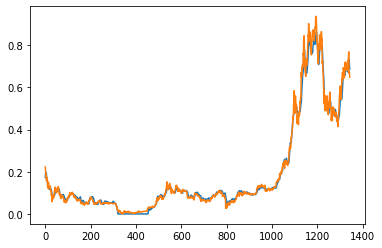

In [34]:
#Plotting the training results
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])

In [35]:
val_predictions = model1.predict(X_val1).flatten()

In [36]:
v_p=val_predictions.tolist()

In [37]:
v_p

[0.6685236692428589,
 0.6552509665489197,
 0.6486028432846069,
 0.650060772895813,
 0.6571475267410278,
 0.6623574495315552,
 0.6734752655029297,
 0.6786154508590698,
 0.6770057678222656,
 0.6744880676269531,
 0.6492947340011597,
 0.6261978149414062,
 0.6110749244689941,
 0.6087548732757568,
 0.6001708507537842,
 0.5996291637420654,
 0.6019775867462158,
 0.6023427248001099,
 0.5905587077140808,
 0.5901424884796143,
 0.5903410911560059,
 0.6043829917907715,
 0.6346758604049683,
 0.6587064266204834,
 0.6823830604553223,
 0.7072082757949829,
 0.7342393398284912,
 0.7531312704086304,
 0.7686266899108887,
 0.7791688442230225,
 0.7832813262939453,
 0.7955515384674072,
 0.8024780750274658,
 0.80744469165802,
 0.8002463579177856,
 0.8210090398788452,
 0.8397687673568726,
 0.8535652160644531,
 0.8535505533218384,
 0.8748542070388794,
 0.8909958600997925,
 0.8919016122817993,
 0.8810017108917236,
 0.8769539594650269,
 0.8599916696548462,
 0.8628755807876587,
 0.8669184446334839,
 0.8596463203430

In [38]:
y_val = y_val1.tolist()

In [39]:
#Converting y_val to a list
flat_list_v = []
for sublist in y_val:
    for item in sublist:
        flat_list_v.append(item)

flat_list_v

[0.6523340897472307,
 0.6657308192726998,
 0.6486284692525371,
 0.6817299113574238,
 0.6985782612705943,
 0.6924693249177505,
 0.6844506818078177,
 0.7001640769039215,
 0.6843371923983105,
 0.6156847221698495,
 0.5822613927670509,
 0.6270434393618313,
 0.647571785087613,
 0.6156217534605617,
 0.6137073103878271,
 0.6213545170515561,
 0.6062323720252066,
 0.5875601155345263,
 0.5957960826661959,
 0.6304071343001125,
 0.6976548011637006,
 0.6913521009233569,
 0.6989452042891345,
 0.7131368454571173,
 0.7504741325210187,
 0.8102694496042959,
 0.78609001173574,
 0.7886061490614474,
 0.8041568092097293,
 0.8011000032364823,
 0.8432764082842532,
 0.8208338623737187,
 0.8419754395316099,
 0.8407384717621772,
 0.9071526077941418,
 0.8962437191444975,
 0.9065256531910593,
 0.913869978541454,
 0.9486268844084557,
 0.9755325577069964,
 0.916731684743301,
 0.8931360888610539,
 0.9040384802571844,
 0.8968446240115293,
 0.9296284900801816,
 0.8880300369851601,
 0.858783895093766,
 0.8920459468766335

In [40]:
len(v_p)

168

In [41]:
val_results = pd.DataFrame(data={'Val Predictions':v_p, 'Actuals':flat_list_v})
val_results

,Val Predictions,Actuals
0,0.668524,0.652334
1,0.655251,0.665731
2,0.648603,0.648628
3,0.650061,0.681730
4,0.657148,0.698578
...,...,...
163,0.543000,0.526014
164,0.527045,0.544835
165,0.519689,0.529454
166,0.521113,0.545559


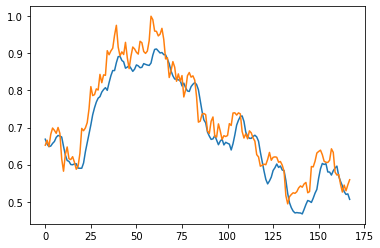

In [42]:
#plotting the validation results
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])

In [43]:
test_predictions = model1.predict(X_test1).flatten()

In [44]:
test_p=test_predictions.tolist()

In [45]:
y_test = y_test1.tolist()

In [46]:
#converting y_test to a list
flat_list_t = []
for sublist in y_test:
    for item in sublist:
        flat_list_t.append(item)

flat_list_t

[0.557568003928956,
 0.5358773177661568,
 0.6211166082733597,
 0.6391704112403214,
 0.632478057955137,
 0.6095909663158696,
 0.5580725429891993,
 0.5621605298892789,
 0.5469172444819949,
 0.5413530451503862,
 0.5518493885629028,
 0.6023025659232898,
 0.5627337455263829,
 0.5527463738797779,
 0.5544413676609347,
 0.5380517117014382,
 0.5662980659376505,
 0.5611998471991706,
 0.5892605135732787,
 0.5862673442512695,
 0.5994769893087389,
 0.6055316401976452,
 0.5908755364864201,
 0.5882355870119781,
 0.6081456006580321,
 0.6164488477606669,
 0.6330503627623091,
 0.639078599583192,
 0.6414429319202596,
 0.6775017173698364,
 0.6822819350181136,
 0.6875318373012425,
 0.6812662382001223,
 0.6575760981709502,
 0.6691254217066681,
 0.6627101428867491,
 0.6717979181706746,
 0.6744266947979527,
 0.6578452787768063,
 0.6213265242116508,
 0.625945039186029,
 0.6070396709547933,
 0.6147261647495822,
 0.6057962059318467,
 0.5640463729021536,
 0.573455367542041,
 0.589614947860755,
 0.5704759213910049

In [47]:
len(test_p)

169

In [48]:
test_results = pd.DataFrame(data={'Test Predictions':test_p, 'Actuals':flat_list_t})
test_results

,Test Predictions,Actuals
0,0.497464,0.557568
1,0.502170,0.535877
2,0.500271,0.621117
3,0.515576,0.639170
4,0.552027,0.632478
...,...,...
164,0.310705,0.309770
165,0.313005,0.321947
166,0.313061,0.322101
167,0.321009,0.329023


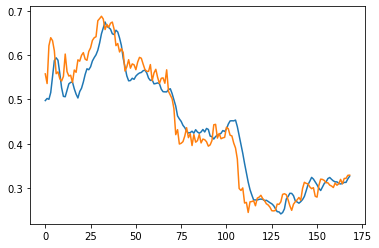

In [49]:
#Plotting the testing results
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actuals'])

In [50]:
#Finding the MSE for the testing results
print('Mean Squared Error:', metrics.mean_squared_error(test_p, flat_list_t))

Mean Squared Error: 0.001338734556712744
